# Approximation

## Outline

1. Setup
2. Polynomial interpolation
3. Resources

## Setup

In many computational economics applications, we need to replace an analytically intractable function $f : R^n \rightarrow R$ with a numerically tractable approximation $\hat{f}$. In some applications, f can be evaluated at any point of its domain, but with difficulty, and we wish to replace it with an approximation $\hat{f}$ that is easier to work with.

We study interpolation, a general strategy for forming a tractable approximation to a function that can be evaluated at any point of its domain. Consider a real-valued function $f$ defined on an interval of the real line that can be evaluated at any point of its domain.

Generally, we will approximate $f$ using a function $\hat{f}$ that is a finite linear combination of n known basis functions $\phi_1, \phi_2, ..., \phi_n$ of our choosing:

\begin{align*}
f(x) \approx \hat{f}(x) \equiv \sum_{j=1}^n c_j \phi_j(x).
\end{align*}

We will fix the n basis coefficients $c_1 , c_2 , ... , c_n$ by requiring $\hat{f}$ to interpolate, that is, agree with $f$ , at $n$ interpolation nodes $x_1 , x_2 , ... , x_n$ of our choosing. 

The most readily recognizable basis is the monomial basis:

\begin{align*}
\phi_0(x) &= 1 \\
\phi_1(x) &= x \\
\phi_2(x) &= x^2 \\
. \\
\phi_n(x)&= x^n.
\end{align*}

This can be used to construct the polynomial approximations:

\begin{align*}
f(x) \approx \hat{f}(x) \equiv c_0 + c_1 x +  c_2 x^2 +  ... c_n x^n
\end{align*}

There are other basis functions with more desirable properties and there are many different ways to choose the interpolation nodes.

Regardless of how the $n$ basis functions and nodes are chosen, computing the basis coefficients reduces to solving a linear equation.

\begin{align*}
\sum_{j=1}^n c_j \phi_j(x) = f(x), \qquad i = 1, ..., n
\end{align*}

Interpolation schemes differ only in how the basis functions $\phi_j$ and interpolation nodes $x_j$ are chosen.




In [1]:
from functools import partial
from temfpy.interpolation import runge
import warnings

from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

from approximation_algorithms import get_interpolator_flexible_basis_flexible_nodes
from approximation_algorithms import get_interpolator_monomial_flexible_nodes
from approximation_algorithms import get_interpolator_monomial_uniform
from approximation_algorithms import get_interpolator_runge_baseline

from approximation_auxiliary import compute_interpolation_error
from approximation_auxiliary import get_chebyshev_nodes
from approximation_auxiliary import get_uniform_nodes

from approximation_plots import plot_two_dimensional_problem
from approximation_plots import plot_reciprocal_exponential
from approximation_plots import plot_runge_different_nodes
from approximation_plots import plot_runge_function_cubic
from approximation_plots import plot_two_dimensional_grid
from approximation_plots import plot_approximation_nodes
from approximation_plots import plot_basis_functions
from approximation_plots import plot_runge_multiple
from approximation_plots import plot_runge

from approximation_problems import problem_reciprocal_exponential
from approximation_problems import problem_two_dimensions

## Polynomial interpolation

A polynomial is an expression consisting of variables and coefficients, that involves only the operations of addition, subtraction, multiplication, and non-negative integer exponentiation of variables. 

The Weierstrass Theorem asserts that any continuous real-valued function can be approximated to an arbitrary degree of accuracy over a bounded interval by a polynomial.

Specifically, if $f$ is continuous on $[a, b]$ and $\epsilon > 0$, then there exists a polynomial $p$ such that 

\begin{align*}
\max_{x\in[a, b]} |f(x) - p(x)| < \epsilon
\end{align*}

* How to find a polynomial that provides a desired degree of accuracy?

* What degree of the polynomial is required?


###  Naive polynomial interpolation

Let's start with a basic setup, where we use a uniform grid and monomial basis functions.

\begin{align*}
\hat{f}(x) \equiv \sum_{j=0}^n c_j x^j
\end{align*}

In [2]:
??get_uniform_nodes

Signature: get_uniform_nodes(n, a=-1, b=1)
Source:   
def get_uniform_nodes(n, a=-1, b=1):
    """Return uniform nodes."""
    return np.linspace(a, b, num=n)
File:      /files/course-repository/labs/approximation/approximation_auxiliary.py
Type:      function


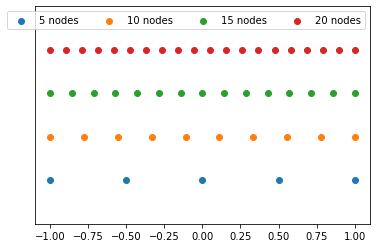

In [3]:
plot_approximation_nodes([5, 10, 15, 20], nodes="uniform")

Now we can get a look at the interpolation nodes.

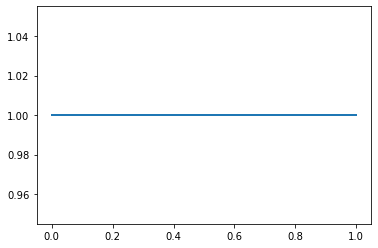

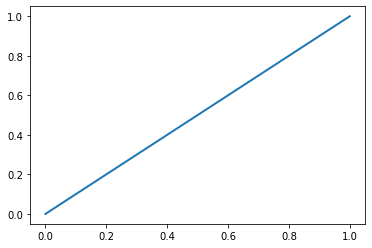

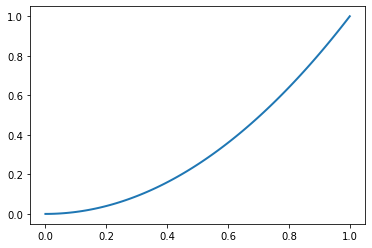

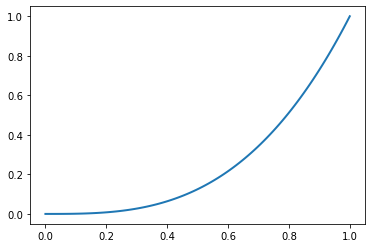

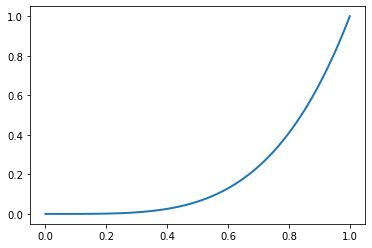

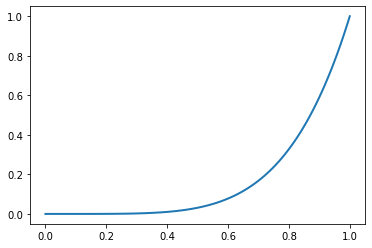

In [4]:
plot_basis_functions("monomial")

Let's look at the performance of this approach for the Runge function for $x\in[0, 1]$.

\begin{align*}
f(x) = \frac{1}{(1 + 25 x^2)}
\end{align*}

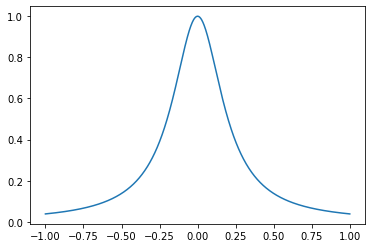

In [5]:
plot_runge()

Due to its frequent use, `numpy` does offer a convenience class to work with polynomials. See [here](https://numpy.org/devdocs/reference/routines.polynomials.html) for its documentation.

In [6]:
from numpy.polynomial import Polynomial as P  # noqa E402
from numpy.polynomial import Chebyshev as C  # noqa E402

We will use the attached methods to develop a flexible interpolation set in an iterative fashion.'

In [7]:
??get_interpolator_runge_baseline

Signature: get_interpolator_runge_baseline(func)
Source:   
def get_interpolator_runge_baseline(func):
    """Return interpolator runge function (baseline)."""
    xnodes = np.linspace(-1, 1, 5)
    poly = np.polynomial.Polynomial.fit(xnodes, func(xnodes), 5)
    return poly
File:      /files/course-repository/labs/approximation/approximation_algorithms.py
Type:      function


In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    interpolant = get_interpolator_runge_baseline(runge)
    xvalues = np.linspace(-1, 1, 10000)
    yfit = interpolant(xvalues)

### _Question_

* Why the warnings?
   

Since we have a good understanding what is causing the warning, we can simply turn it of going forward. A documentation that shows how to deal with more fine-grained filters is available [here](https://pymotw.com/3/warnings/).

In [9]:
warnings.simplefilter("ignore")

Now we are read to plot it against the true function.

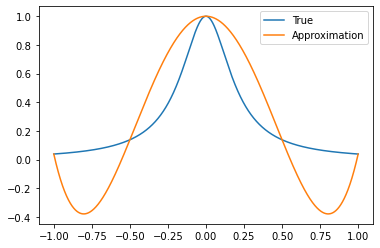

In [10]:
fig, ax = plt.subplots()
ax.plot(xvalues, runge(xvalues), label="True")
ax.plot(xvalues, yfit, label="Approximation")
ax.legend()

We evaluate the error in our approximation by the  the following statistic.

In [11]:
??compute_interpolation_error

Signature: compute_interpolation_error(error)
Source:   
def compute_interpolation_error(error):
    """Compute interpolation error."""
    return np.log10(np.linalg.norm(error, np.inf))
File:      /files/course-repository/labs/approximation/approximation_auxiliary.py
Type:      function


In [12]:
compute_interpolation_error(yfit - runge(xvalues))

-0.35817192020499805

### _Exercises_

1. Generalize the function to allow to approximate the function with a polynomial of generic degree.
2. How does the quality of the approximation change as we increase the number of interpolation points?

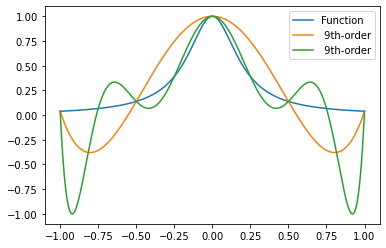

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_runge_multiple()

What can be done? First we explore a different way to choose the the nodes.

Theory asserts that the best way to approximate a continuous function with a polynomial over a bounded interval $[a, b]$ is to interpolate it at so called Chebychev nodes:

\begin{align*}
x_i = \frac{a + b}{2} + \frac{b - a}{2}\cos\left(\frac{n - i + 0.5}{n}\pi\right)
\end{align*}



In [14]:
??get_chebyshev_nodes

Signature: get_chebyshev_nodes(n, a=-1, b=1)
Source:   
def get_chebyshev_nodes(n, a=-1, b=1):
    """Return Chebyshev nodes."""
    nodes = np.tile(np.nan, n)

    for i in range(1, n + 1):
        nodes[i - 1] = (a + b) / 2 + ((b - a) / 2) * np.cos(((n - i + 0.5) / n) * np.pi)

    return nodes
File:      /files/course-repository/labs/approximation/approximation_auxiliary.py
Type:      function


Let's look at a visual representation.

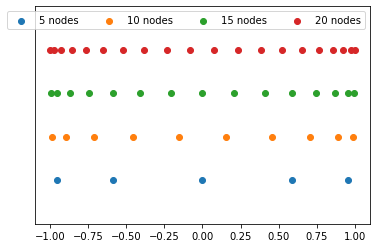

In [15]:
plot_approximation_nodes([5, 10, 15, 20], nodes="chebychev")

The Chebychev nodes are not evenly spaced and do not include the endpoints of the approximation interval. They are more closely spaced near the endpoints of the approximation interval and less so near the center.


If $f$ is continuous ...

* Rivlin’s Theorem asserts that Chebychev-node polynomial interpolation is nearly optimal, that is, it affords an approximation error that is very close to the lowest error attainable with another polynomial of the same degree.

* Jackson’s Theorem asserts that Chebychev-node polynomial interpolation is consistent, that is, the approximation error vanishes as the degree of the polynomial increases.

In [16]:
??get_interpolator_monomial_flexible_nodes

Signature:
get_interpolator_monomial_flexible_nodes(
    func,
    degree,
    nodes='uniform',
    a=-1,
    b=1,
)
Source:   
def get_interpolator_monomial_flexible_nodes(func, degree, nodes="uniform", a=-1, b=1):
    """Return monomial function (flexible nodes)."""
    if nodes == "uniform":
        get_nodes = get_uniform_nodes
    elif nodes == "chebychev":
        get_nodes = get_chebyshev_nodes

    xnodes = get_nodes(degree, a, b)
    poly = np.polynomial.Polynomial.fit(xnodes, func(xnodes), degree)

    return poly
File:      /files/course-repository/labs/approximation/approximation_algorithms.py
Type:      function


In [17]:
intertp = get_interpolator_monomial_flexible_nodes(runge, 11, nodes="chebychev")
intertp(np.linspace(-1, 1, 10))

array([-0.00532688,  0.04177453,  0.12887422,  0.20826539,  0.85508579,
        0.85508579,  0.20826539,  0.12887422,  0.04177453, -0.00532688])

Let's compare the performance of the two approaches.

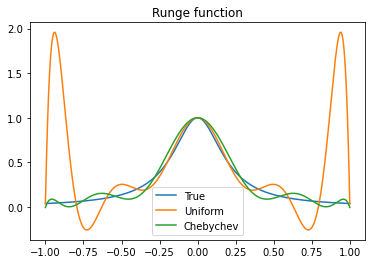

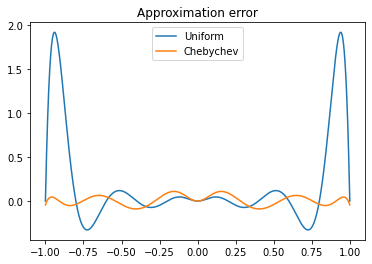

In [18]:
plot_runge_different_nodes()

However, merely interpolating at the Chebychev nodes does not eliminate ill-conditioning. Ill-conditioning stems from the choice of basis functions,
not the choice of interpolation nodes. Fortunately, there is alternative to the monomial basis that is ideal for expressing Chebychev-node polynomial interpolants. The optimal basis for expressing Chebychev-node
polynomial interpolants is called the Chebychev polynomial basis.

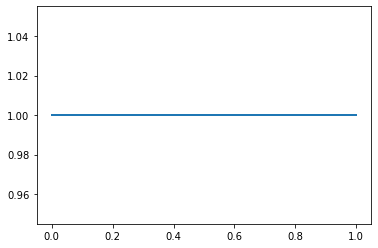

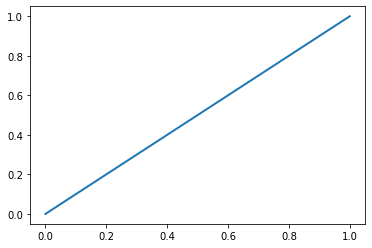

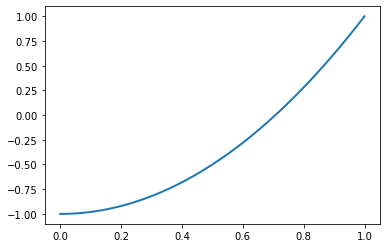

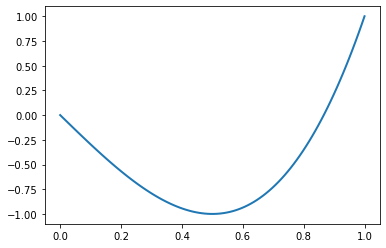

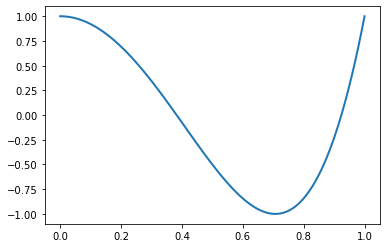

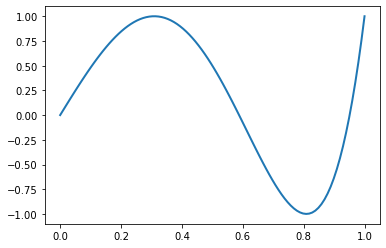

In [19]:
plot_basis_functions("chebychev")

Combining the Chebychev basis polynomials and Chebychev interpolation nodes yields an extremely well-conditioned interpolation equation and allows to approximate any continuous function to high precision. Let's put it all together now.

In [20]:
??get_interpolator_flexible_basis_flexible_nodes

Signature:
get_interpolator_flexible_basis_flexible_nodes(
    func,
    degree,
    basis='monomial',
    nodes='uniform',
    a=-1,
    b=1,
)
Source:   
def get_interpolator_flexible_basis_flexible_nodes(
    func, degree, basis="monomial", nodes="uniform", a=-1, b=1
):
    """Return interpolator (flexible basis, flexible nodes)."""
    if nodes == "uniform":
        get_nodes = get_uniform_nodes
    elif nodes == "chebychev":
        get_nodes = get_chebyshev_nodes

    if basis == "monomial":
        fit = np.polynomial.Polynomial.fit
    elif basis == "chebychev":
        fit = np.polynomial.Chebyshev.fit

    xnodes = get_nodes(degree, a, b)
    poly = fit(xnodes, func(xnodes), degree)

    return poly
File:      /files/course-repository/labs/approximation/approximation_algorithms.py
Type:      function


How well can we actually do now?

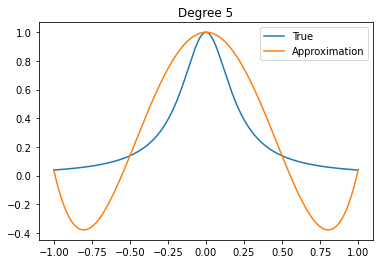

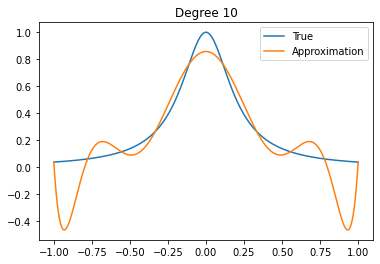

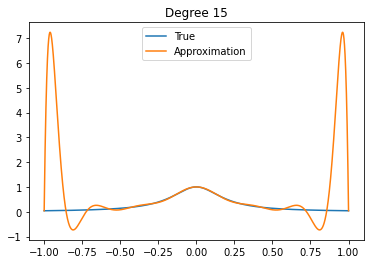

In [21]:
for degree in [5, 10, 15]:
    interp = get_interpolator_flexible_basis_flexible_nodes(
        runge, degree, nodes="uniform", basis="monomial"
    )
    xvalues = np.linspace(-1, 1, 10000)
    yfit = interp(xvalues)

    fig, ax = plt.subplots()
    ax.plot(xvalues, runge(xvalues), label="True")
    ax.plot(xvalues, yfit, label="Approximation")
    ax.legend()
    ax.set_title(f"Degree {degree}")

###  Spline interpolation

Piecewise polynomial splines, or simply splines for short, are a rich, flexible class of functions that may be used instead of high degree polynomials to approximate a real-valued function over a bounded interval. Generally, an order $k$ spline consists of a series of $k^{th}$
degree polynomial segments spliced together so as to preserve continuity of derivatives of order $k - 1$ or less

* A first-order or **linear spline** is a series of line segments spliced together to form a continuous function.

* A third-order or **cubic spline** is a series of cubic polynomials segments spliced together to form a twice continuously differentiable function.


<img src="material/fig-spline-two.png" width=500 height=500 />
<img src="material/fig-spline-four.png" width=500 height=500 />
<img src="material/fig-spline-eight.png" width=500 height=500 />


A linear spline with n + 1 evenly-spaced interpolation nodes $x_0 , x_1 , ... , x_n$ on the interval $[a, b]$ may be written as a linear combination of the $n + 1$ basis functions:

\begin{align*}
\phi_j(x) = \begin{cases}
1 - \frac{|x - x_j|}{h} & \qquad |x - x_j| \leq h \\
0  & \\
\end{cases}
\end{align*}

where $h = (b - a)/n$ is the distance between the nodes.


The linear spline approximant of $f$  takes thus the form:

\begin{align*}
\hat{f}(x) = \sum_{j=1}^{n} f(x_j)\phi_j(x)
\end{align*}

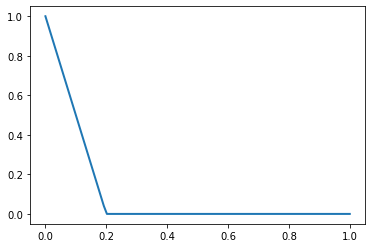

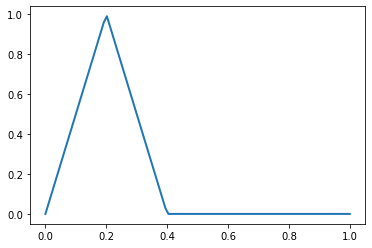

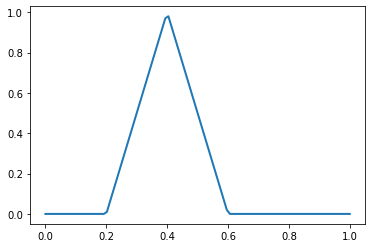

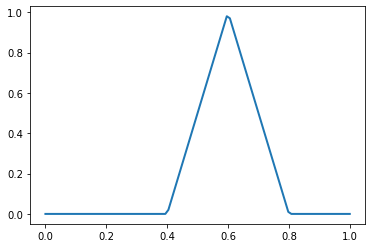

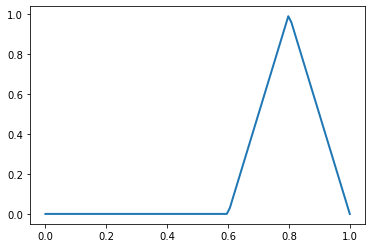

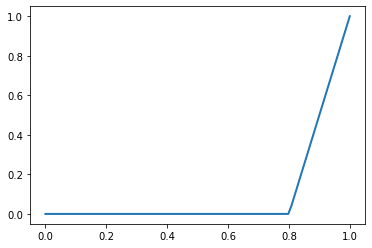

In [22]:
plot_basis_functions("linear")

This kind of interpolation procedure is frequently used in practice and readily available in `scipy`. The `interp1` function is documented [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html). 

In [23]:
x_fit = get_uniform_nodes(10, -1, 1)
f_inter = interp1d(x_fit, runge(x_fit))
f_inter(0.5)

array(0.15222463)

Let's get a feel for this approach using our earlier test function.

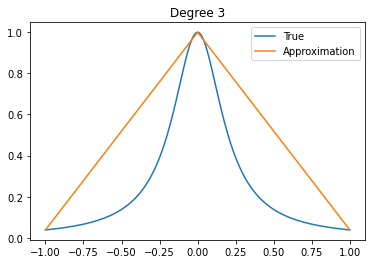

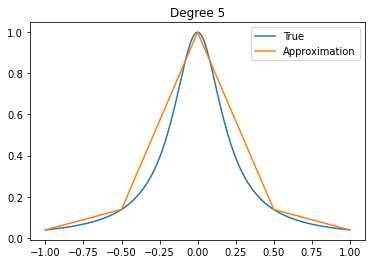

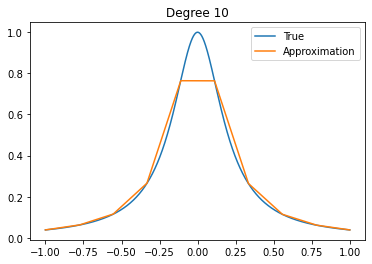

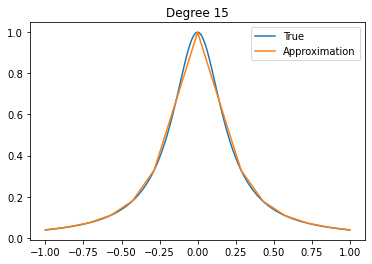

In [24]:
x_eval = get_uniform_nodes(10000, -1, 1)

for degree in [3, 5, 10, 15]:
    x_fit = get_uniform_nodes(degree, -1, 1)

    interp = interp1d(x_fit, runge(x_fit))
    yfit = interp(xvalues)

    fig, ax = plt.subplots()
    ax.plot(xvalues, runge(xvalues), label="True")
    ax.plot(xvalues, yfit, label="Approximation")
    ax.legend()
    ax.set_title(f"Degree {degree}")

### _Question_

* How about other ways to place the interpolation nodes?

Another widely-used specification relies on cubic splines. Here are the corresponding basis functions.

<img src="material/fig-cubic-spline-basis.png" width=500 height=500 />


It is directly integrated into the `interp1` function.

In [25]:
x_fit = get_uniform_nodes(10, -1, 1)
f_inter = interp1d(x_fit, runge(x_fit), kind="cubic")
f_inter(0.5)

array(0.12635205)

How about approximating Runge's function.

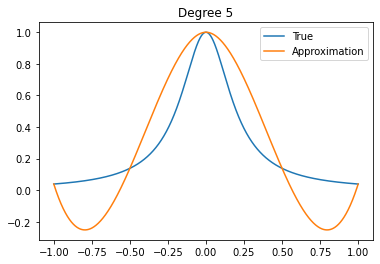

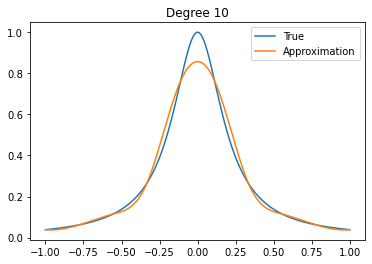

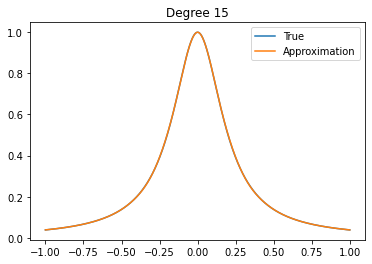

In [26]:
plot_runge_function_cubic()

Let's take stock of our interpolation toolkit by running a final benchmarking exercise and then try to extract some 



### _Exercises_

Let's consider two test functions: problem_reciprocal_exponential, problem_kinked. 

1. Visualize both over the range from -1 to 1. What is the key differences in their properties?
2. Set up a function that allows you to flexibly interpolate using either Chebychev polynomials (monomial basis, Chebychev nodes) or linear and cubic splines.         
3. Compare the performance for the following degrees: 10, 20, 30.

We collect some rules-of-thumb:

* Chebychev-node polynomial interpolation dominates spline function interpolation whenever the function is smooth.

* Spline interpolation may perform better than polynomial interpolation if the underlying function exhibits a high degree of curvature or a derivative discontinuity.

### Multidimensional interpolation

Univariate interpolation methods can be extended to higher dimensions by applying tensor product principles. We consider the problem of interpolating a bivariate real-valued function $f$ over an interval:

\begin{align*}
I = \{(x, y) | a_x \leq x \leq b_x, a_y \leq y \leq b_y\}
\end{align*}


Let $\phi_{x_1} , \phi_{x_2} , ... , \phi_{x_n}$  x and $x_1 , x_2 , . . . , x_{n_x}$ be $n_x$ univariate basis functions and $n_x$ interpolation nodes for the interval $[a_x , b_x]$ and let $\phi_{y_1} , \phi_{y_2} , ... , \phi_{y_n}$  x and $y_1 , y_2 , . . . , y_{n_y}$ be $n_x$ univariate basis functions and $n_y$ interpolation nodes for the interval $[a_y , b_y]$.

Then an $n = n_x n_y$ bivariate function basis defined on $I$ may be obtained by forming the tensor product of the univariate basis functions: $\phi_{ij} (x, y) = \phi^x_i (x) \phi^y_j(y)$ for $i = 1, 2, ... , n_x$ and $j = 1, 2, ... , n_y$. Similarly, a grid of $n = n_x n_y$ interpolation nodes for $I$ may be obtained by forming the Cartesian product of the univariate interpolation nodes

\begin{align*}
\{ (x_i , y_j ) | i = 1, 2, . . . , n_x ; j = 1, 2, . . . , n_y \}.
\end{align*}

Typically, multivariate tensor product interpolation schemes inherit the favorable qualities of their univariate parents. An approximant for $f$ then takes the form:

\begin{align*}
\hat{f}(x_1, x_2) = \sum_{i=1}^{n_x} \sum_{j=1}^{n_y} c_{ij}\phi_{ij}(x_i, y_j)
\end{align*}

However, this straightforward extension to the multivariate setting suffers from the **curse of dimensionality**. For example, the number of interpolation nodes increases exponentially in the number of dimensions.


As an aside, we now move to the multidimensional setting where we often have to apply the same operation across multidimensional arrays and `numpy` provides some suitable capabilities to do this very fast if one makes an effort in understanding its [broadcasting rules](https://numpy.org/doc/stable/user/theory.broadcasting.html#array-broadcasting-in-numpy).

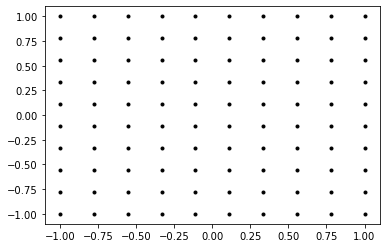

In [27]:
plot_two_dimensional_grid("uniform")

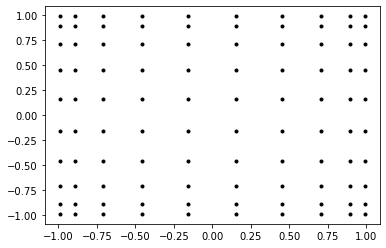

In [28]:
plot_two_dimensional_grid("chebychev")

Let's see how we can transfer the ideas to polynomial interpolation to the two-dimensional setting.

\begin{align*}
f(x, y) = \frac{\cos(x)}{\sin(y)}
\end{align*}

In [29]:
??plot_two_dimensional_problem

Signature: plot_two_dimensional_problem()
Source:   
def plot_two_dimensional_problem():
    """Plot two-dimensional problem."""
    x_fit = get_uniform_nodes(50)
    y_fit = get_uniform_nodes(50)
    X_fit, Y_fit = np.meshgrid(x_fit, y_fit)
    Z_fit = problem_two_dimensions(X_fit, Y_fit)

    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.plot_surface(X_fit, Y_fit, Z_fit)
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.set_zlabel("f(x, y)")
File:      /files/course-repository/labs/approximation/approximation_plots.py
Type:      function


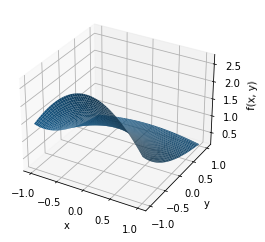

In [30]:
plot_two_dimensional_problem()

Now, let's fit a two-dimensional polynomial approximation. We will have to rely on the `scikit-learn` library.

In [31]:
from sklearn.preprocessing import PolynomialFeatures  # noqa: E402
from sklearn.linear_model import LinearRegression  # noqa: E402
import sklearn  # noqa: E402

We first need to set up an approximating model using some of its provided functionality. One of the functions at the core of this workflow is `np.meshgrid` which takes a bit of getting used to. Let's check out its [documentation](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) first and so some explorations.

In [32]:
x_fit, y_fit = get_chebyshev_nodes(100), get_chebyshev_nodes(100)

We now combine the univariate interpolation nodes into a two-dimensional grid, adjust it to meet the structure  expected by `scikit-learn`, expand it to contain all polynomials (including interactions), and fit a linear regression model.

In [33]:
X_fit, Y_fit = np.meshgrid(x_fit, y_fit)
grid_fit = np.array(np.meshgrid(x_fit, y_fit)).T.reshape(-1, 2)
y = [problem_two_dimensions(*point) for point in grid_fit]

poly = PolynomialFeatures(degree=6)
X_poly = poly.fit_transform(grid_fit)
clf = LinearRegression().fit(X_poly, y)

How well are we doing? As usual, we will simply compare the true and approximated values of the function over a fine grid. 

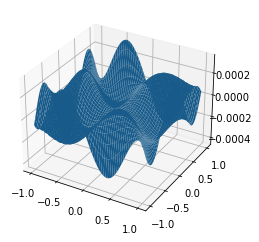

In [34]:
x_eval = get_uniform_nodes(100)
y_eval = get_uniform_nodes(100)

Z_eval = np.tile(np.nan, (100, 100))
Z_true = np.tile(np.nan, (100, 100))

for i, x in enumerate(x_eval):
    for j, y in enumerate(y_eval):
        point = [x, y]
        Z_eval[i, j] = clf.predict(poly.fit_transform([point]))[0]
        Z_true[i, j] = problem_two_dimensions(*point)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot_surface(*np.meshgrid(x_eval, y_eval), Z_eval - Z_true)


## Resources


* https://relate.cs.illinois.edu/course/cs450-f18/file-version/a7a1965adf0479d36f1a34889afe55e2ec61a532/demos/upload/07-interpolation/Chebyshev%20interpolation.html

* https://www.unioviedo.es/compnum/labs/PYTHON/Interpolation.html

* https://www.johndcook.com/blog/2017/11/06/chebyshev-interpolation/

* https://numpy.org/devdocs/reference/routines.polynomials.html